# This notebook checks the results after a simulation

## init stuff

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

In [3]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np


In [4]:
import sumolib

In [5]:
from utils.data_utils.network_utils import flatten, get_downstream_edges, get_upstream_edges, get_edge_to_level_dict
from utils.result_utils.plot_utils import plotNet
from utils.result_utils.file_utils import xml2csv_path
from utils.result_utils.dotdict import DotDict
from utils.general_utils.conversion_utils import convert_seconds_to_24h
from utils.data_utils.data_loader_utils import transform_df_to_tensor, get_index_to_edge_dicts

In [6]:
scenario = 'motorway'
experiment_name = 'incident3'
path = f'../{scenario}/Results/{experiment_name}'


In [7]:
result_folders = os.listdir(path)
print(f'{len(result_folders)} simulations')
#result_folders

1998 simulations


In [8]:

experiment_folders = [folder for folder in result_folders if folder.startswith(experiment_name)]

In [9]:
print(f'{len(experiment_folders)} experiments')

1998 experiments


In [10]:
for folder in experiment_folders:
    result_xmls = [xml for xml in glob.glob(f'{path}/{folder}/*.xml') if 'log' not in xml]
    if len(glob.glob(f'{path}/{folder}/*.csv')) < len(result_xmls):
        print(f'Found fewer csv files than xml files in {folder}. Converting results')
        xml2csv_path(f'{path}/{folder}')
        print(f'finished converting {folder}')
    #else: print(f"All files in {folder} seems converted.")

# Load incident and net

In [30]:
net_path = '../motorway/Simulations/Base/network.net.xml'
net = sumolib.net.readNet(net_path)

In [87]:
# 16 shows not smooth enough
experiment = experiment_folders[5]
experiment_path = f'{path}/{experiment}'
#experiment_path = f'{path}/incident1_257'

print(experiment_path)
#os.listdir(experiment_path)

with open(f'{experiment_path}/incident_settings.json') as f:
    incident_settings = json.load(f)
print(incident_settings)

incident_edge = incident_settings['edge']
i_edge_obj = net.getEdge(incident_edge)

hours, minutes, seconds = convert_seconds_to_24h(incident_settings['start_time'])
print(f'Incident at {hours}:{minutes}:{seconds}')

n_up = 6
n_down = 6

downstream_edges_ids = get_downstream_edges(i_edge_obj, n_up)
all_downstream_edges_ids = flatten(list(downstream_edges_ids.values()))

upstream_edges_ids = get_upstream_edges(i_edge_obj, n_down)
all_upstream_edges_ids = flatten(list(upstream_edges_ids.values()))

edge_to_level_dict = get_edge_to_level_dict(upstream_edges_ids, downstream_edges_ids, incident_edge)

relevant_edges = all_upstream_edges_ids + all_downstream_edges_ids + [incident_edge]
upstream_edges = all_upstream_edges_ids + [incident_edge]
downstream_edges = all_downstream_edges_ids + [incident_edge]

edge_to_level_dict

../motorway/Results/incident3/incident3_1175
{'slow_zone': 70, 'lc_zone': 20, 'lc_prob_zone': 170, 'slow_zone_speed': 13.8, 'run_num': 1175, 'is_incident': True, 'is_random': True, 'random_seed': 1307721398, 'edge': '360361373-AddedOnRampEdge', 'lanes': [1, 2, 3, 4], 'pos': 30.702817167882127, 'start_time': 38135, 'start_step': 76270, 'duration_time': 1224, 'duration_steps': 2448}
Incident at 10:35:35


{'22941416#1': 'upstream_0_0',
 '4937552#1': 'upstream_0_1',
 '22941416#0': 'upstream_1_0',
 '4937552#1-AddedOnRampEdge': 'upstream_1_1',
 '54121214': 'upstream_2_0',
 '28458824': 'upstream_2_1',
 '4937552#0': 'upstream_2_2',
 '431199180': 'upstream_3_0',
 '261583464': 'upstream_3_1',
 '75259388-AddedOffRampEdge.122': 'upstream_3_2',
 '22941414': 'upstream_4_0',
 '26378010': 'upstream_4_1',
 '75259388-AddedOffRampEdge.76': 'upstream_4_2',
 '261187938-AddedOffRampEdge': 'upstream_5_0',
 '457424511#3.414': 'upstream_5_1',
 '75259388-AddedOffRampEdge.702': 'upstream_5_2',
 '261187938': 'upstream_6_0',
 '457424511#3': 'upstream_6_1',
 '75259388-AddedOffRampEdge.381': 'upstream_6_2',
 '360361373': 'downstream_0_0',
 '360361373.463': 'downstream_1_0',
 '360361373.981': 'downstream_2_0',
 '360361373.1498': 'downstream_3_0',
 '360361373.1899': 'downstream_4_0',
 '360361373.2215': 'downstream_5_0',
 '360361373.2643': 'downstream_6_0',
 '360361373-AddedOnRampEdge': 'incident_edge'}

<AxesSubplot:>

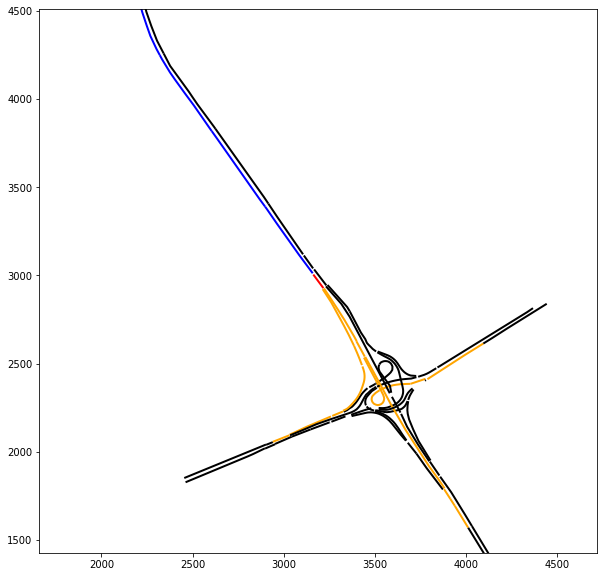

In [88]:
#net_path = '../experiment/Simulations/Base/traci_exp.net.xml'
net_path = '../motorway/Simulations/Base/network.net.xml'
net = sumolib.net.readNet(net_path)
plot_options = {'defaultColor': 'black',
                'defaultWidth': 2}
plot_options = DotDict(plot_options)
edge_colors = {incident_edge: 'red'}

for i in range(n_up):
    for id in upstream_edges_ids[i]:
        edge_colors[id] = 'orange'
        
for i in range(n_down):
    for id in downstream_edges_ids[i]:
        edge_colors[id] = 'blue'
        
fig, ax = plt.subplots(1, figsize=(10,10))
plotNet(net, edge_colors, {}, plot_options, i_edge_obj, ax, margin=1500)


## check edge level counterfactuals

In [89]:
results_incident = pd.read_csv(f'{experiment_path}/edgedata.csv', sep=';')
results_incident = results_incident[['edge_id', 'interval_begin', 'edge_density', 'edge_occupancy', 'edge_speed', 'edge_waitingTime', 'edge_timeLoss']]
results_incident_table = results_incident.pivot(index='edge_id', columns='interval_begin', values=['edge_speed','edge_density'])

counterfactual_incident = pd.read_csv(f'{experiment_path}/edgedata_counterfactual.csv', sep=';')
counterfactual_incident = counterfactual_incident[['edge_id', 'interval_begin', 'edge_density', 'edge_occupancy', 'edge_speed', 'edge_waitingTime', 'edge_timeLoss']]
counterfactual_incident_table = counterfactual_incident.pivot(index='edge_id', columns='interval_begin', values=['edge_speed','edge_density'])



In [90]:
results_incident

edge_id  interval_begin  edge_density  \
0                       106130759         36935.0         19.48   
1      106130759-AddedOffRampEdge         36935.0           NaN   
2                  106130759.1186         36935.0         16.04   
3                  106130759.1630         36935.0          7.04   
4                  106130759.1868         36935.0          3.21   
...                           ...             ...           ...   
35275                       gneE2         51275.0         48.88   
35276                       gneE3         51275.0         42.26   
35277                       gneE4         51275.0         39.87   
35278                       gneE6         51275.0         42.06   
35279                       gneE7         51275.0         44.04   

       edge_occupancy  edge_speed  edge_waitingTime  edge_timeLoss  
0                2.53       27.26               0.0          36.03  
1                 NaN         NaN               NaN            NaN  
2                2.07       27.66               0.0          11.51  
3                0.89       27.88               0.0           1.59  
4                0.42       27.90               0.0           0.51  
...               ...         ...               ...            ...  
35275            5.99       25.47               0.0          28.06  
35276            5.20       25.96               0.0          23.33  
35277            4.87       26.02               0.0          21.44  
35278            5.13       25.62               0.0          20.25  
35279            5.46       25.58               0.0          34.85  

[35280 rows x 7 columns]

In [91]:
results_incident_table.iloc[0].loc['edge_speed'].index[1] - results_incident_table.iloc[0].loc['edge_speed'].index[0]

60.0

In [92]:
upstream_edges

['22941416#1',
 '4937552#1',
 '22941416#0',
 '4937552#1-AddedOnRampEdge',
 '54121214',
 '28458824',
 '4937552#0',
 '431199180',
 '261583464',
 '75259388-AddedOffRampEdge.122',
 '22941414',
 '26378010',
 '75259388-AddedOffRampEdge.76',
 '261187938-AddedOffRampEdge',
 '457424511#3.414',
 '75259388-AddedOffRampEdge.702',
 '261187938',
 '457424511#3',
 '75259388-AddedOffRampEdge.381',
 '360361373-AddedOnRampEdge']

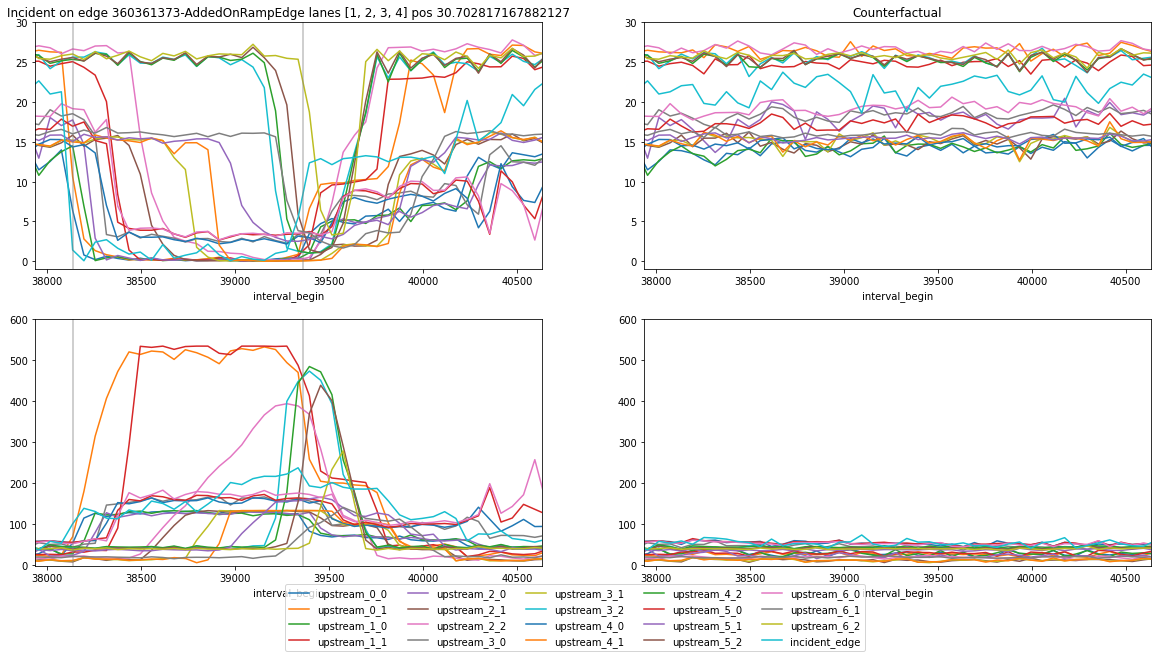

In [93]:
chosen_edges = upstream_edges
#chosen_edges = ['106130759']

fig, ax = plt.subplots(2,2)

results_incident_table.loc[chosen_edges].edge_speed.T.plot(figsize=(20,10), ax=ax[0,0], legend=False)
ax[0,0].set_title(f'Incident on edge {incident_settings["edge"]} lanes {incident_settings["lanes"]} pos {incident_settings["pos"]}')
results_incident_table.loc[chosen_edges].edge_density.T.plot(figsize=(20,10), ax=ax[1,0], legend=False)

counterfactual_incident_table.loc[chosen_edges].edge_speed.T.plot(figsize=(20,10), ax=ax[0,1], legend=False)
ax[0,1].set_title(f'Counterfactual')
counterfactual_incident_table.loc[chosen_edges].edge_density.T.plot(figsize=(20,10), ax=ax[1,1], legend=False)

ax[0,0].set_xlim(incident_settings['start_time'] - 200 ,incident_settings['start_time'] + 2500)
ax[1,0].set_xlim(incident_settings['start_time'] - 200 ,incident_settings['start_time'] + 2500)
ax[0,1].set_xlim(incident_settings['start_time'] - 200 ,incident_settings['start_time'] + 2500)
ax[1,1].set_xlim(incident_settings['start_time'] - 200 ,incident_settings['start_time'] + 2500)
ax[0,0].set_ylim(-1, 30)
ax[1,0].set_ylim(-1, 600)
ax[0,1].set_ylim(-1, 30)
ax[1,1].set_ylim(-1, 600)


ax[0,0].axvline(incident_settings['start_time'], color='grey', alpha=0.5)
ax[1,0].axvline(incident_settings['start_time'], color='grey', alpha=0.5)
ax[0,0].axvline(incident_settings['start_time'] + incident_settings['duration_time'], color='grey', alpha=0.5)
ax[1,0].axvline(incident_settings['start_time'] + incident_settings['duration_time'], color='grey', alpha=0.5)

handles, labels = ax[0,0].get_legend_handles_labels()
lgd = fig.legend(handles, [edge_to_level_dict[label] for label in labels], loc='lower center', bbox_to_anchor=(0.5, 0.0), ncol=5)
plt.savefig('fig1.png', bbox_extra_artists=(lgd,), bbox_inches='tight')

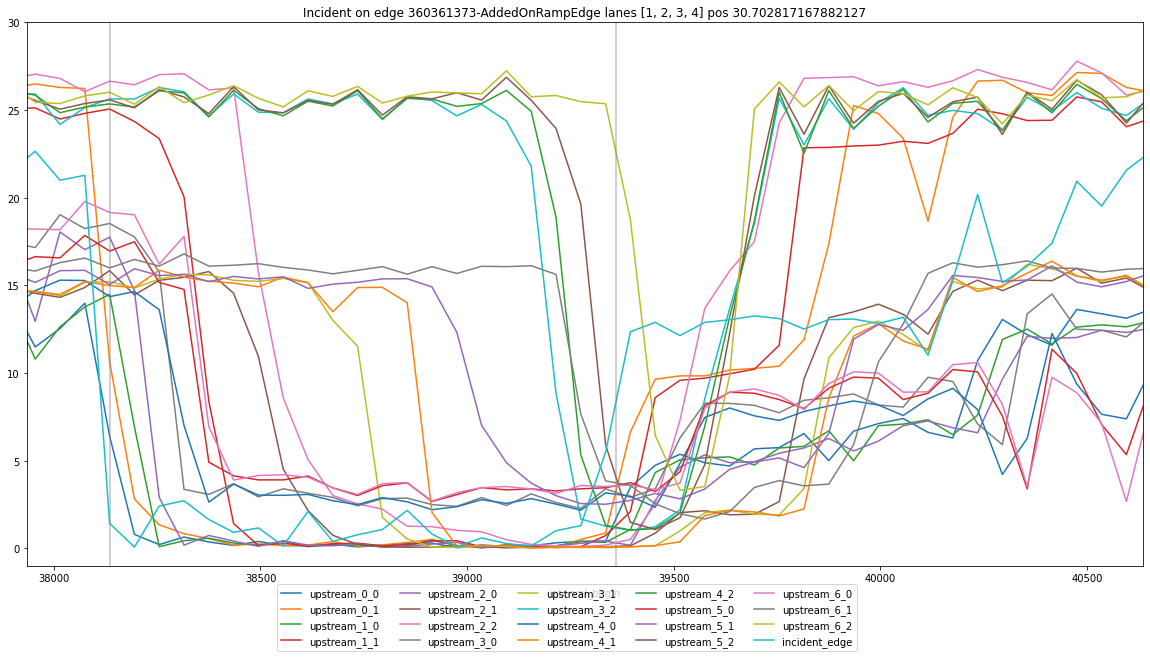

In [94]:
chosen_edges = upstream_edges


fig, ax = plt.subplots(1,1)

results_incident_table.loc[chosen_edges].edge_speed.T.plot(figsize=(20,10), ax=ax, legend=False)
ax.set_title(f'Incident on edge {incident_settings["edge"]} lanes {incident_settings["lanes"]} pos {incident_settings["pos"]}')

ax.set_xlim(incident_settings['start_time'] - 200 ,incident_settings['start_time'] + 2500)
ax.set_ylim(-1, 30)


ax.axvline(incident_settings['start_time'], color='grey', alpha=0.5)
ax.axvline(incident_settings['start_time'] + incident_settings['duration_time'], color='grey', alpha=0.5)

handles, labels = ax.get_legend_handles_labels()
lgd = fig.legend(handles, [edge_to_level_dict[label] for label in labels], loc='lower center', bbox_to_anchor=(0.5, 0.0), ncol=5)
plt.savefig('fig1.png', bbox_extra_artists=(lgd,), bbox_inches='tight')

# Attempt at backlog

<AxesSubplot:xlabel='interval_begin'>

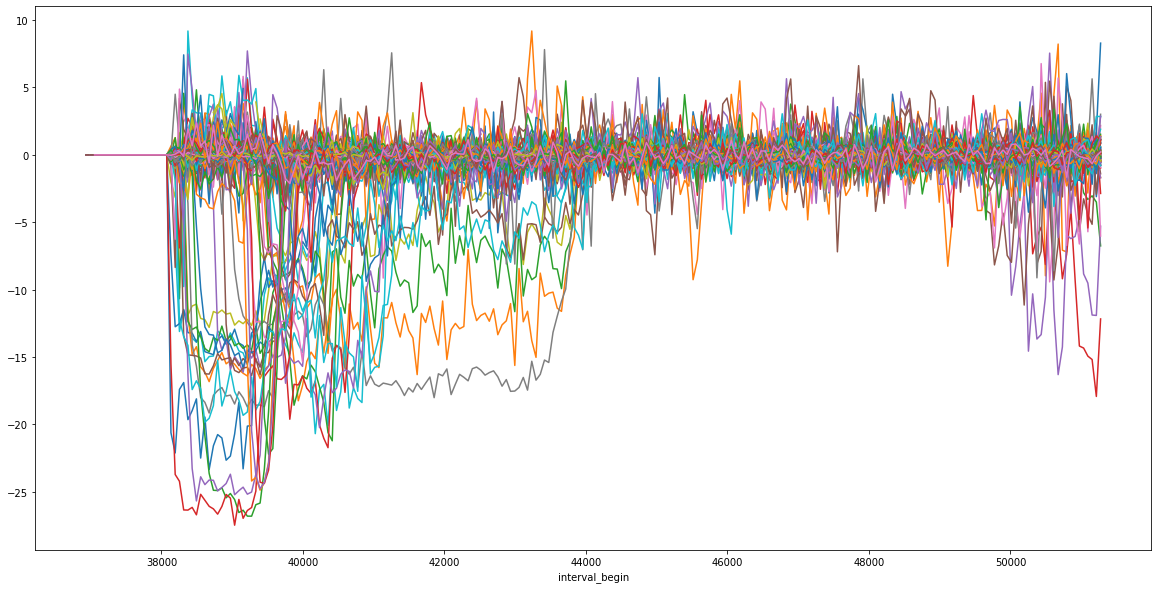

In [95]:
fig, ax = plt.subplots(1)
(results_incident_table.edge_speed - counterfactual_incident_table.edge_speed).T.plot(figsize=(20,10), legend=False, ax=ax)
#ax.set_xlim(incident_settings['start_time'] - 200 ,incident_settings['start_time'] + 5000)



In [96]:
edge_colors_2 = {}
for handle in handles:
        edge_colors_2[handle.get_label()] = handle.get_color()

<AxesSubplot:>

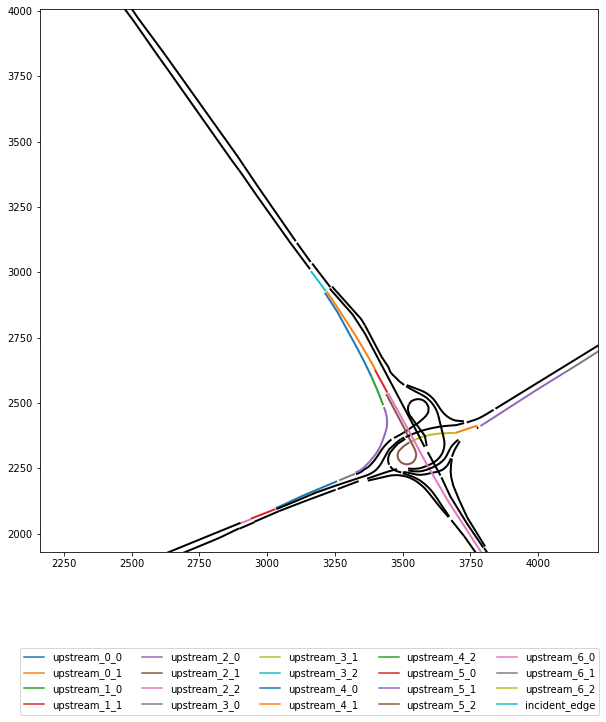

In [97]:
# 3 area = {'xmin':500 , 'xmax':3000 ,'ymin':4000 ,'ymax':8000 }
#area = {'xmin':2000 , 'xmax':2500 ,'ymin':5700 ,'ymax':6800 }
fig, ax = plt.subplots(1, figsize=(10,10))
#plotNet(net, edge_colors_2, {}, plot_options, i_edge_obj, ax, area=area)
fig.legend(handles, [edge_to_level_dict[label] for label in labels], loc='upper center', bbox_to_anchor=(0.5, -0.001), ncol=5)
plotNet(net, edge_colors_2, {}, plot_options, i_edge_obj, ax, margin=1000)

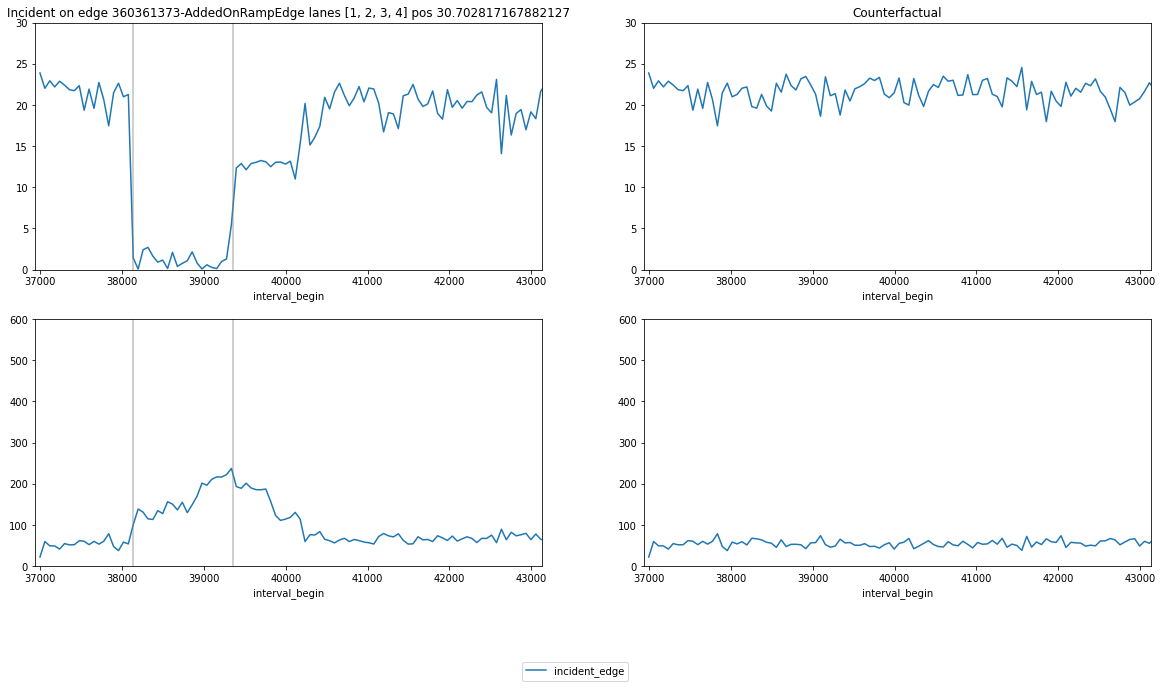

In [98]:
chosen_edges = incident_edge


fig, ax = plt.subplots(2,2)

results_incident_table.loc[chosen_edges].edge_speed.T.plot(figsize=(20,10), ax=ax[0,0], legend=False)
ax[0,0].set_title(f'Incident on edge {incident_settings["edge"]} lanes {incident_settings["lanes"]} pos {incident_settings["pos"]}')
results_incident_table.loc[chosen_edges].edge_density.T.plot(figsize=(20,10), ax=ax[1,0], legend=False)

counterfactual_incident_table.loc[chosen_edges].edge_speed.T.plot(figsize=(20,10), ax=ax[0,1], legend=False)
ax[0,1].set_title(f'Counterfactual')
counterfactual_incident_table.loc[chosen_edges].edge_density.T.plot(figsize=(20,10), ax=ax[1,1], legend=False)

ax[0,0].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 5000)
ax[1,0].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 5000)
ax[0,1].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 5000)
ax[1,1].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 5000)
ax[0,0].set_ylim(0, 30)
ax[1,0].set_ylim(0, 600)
ax[0,1].set_ylim(0, 30)
ax[1,1].set_ylim(0, 600)


ax[0,0].axvline(incident_settings['start_time'], color='grey', alpha=0.5)
ax[1,0].axvline(incident_settings['start_time'], color='grey', alpha=0.5)
ax[0,0].axvline(incident_settings['start_time'] + incident_settings['duration_time'], color='grey', alpha=0.5)
ax[1,0].axvline(incident_settings['start_time'] + incident_settings['duration_time'], color='grey', alpha=0.5)

handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, [edge_to_level_dict[label] for label in labels], loc='upper center', bbox_to_anchor=(0.5, -0.001), ncol=5)

## Compare edge with detector data

In [99]:
results_detector = pd.read_csv(f'{experiment_path}/detectordata.csv', sep=';')
#results_detector = results_detector.replace(-1,np.nan)
results_detector_table = results_detector.pivot(index='interval_id', columns='interval_begin', values=['interval_flow',
                                                                                                       'interval_harmonicMeanSpeed',
                                                                                                       'interval_nVehContrib',
                                                                                                       'interval_speed'])
#results_detector_table = results_detector_table.groupby(results_detector_table.index.str.split('_').str[1]).mean().T

In [100]:





counterfactual_detector = pd.read_csv(f'{experiment_path}/detectordata_counterfactual.csv', sep=';')
counterfactual_detector = counterfactual_detector.replace(-1,np.nan)



#results_detector_table = results_detector_table.groupby(results_detector_table.index.str.split('_').str[1]).mean().T
#counterfactual_detector_table = counterfactual_detector_table.groupby(counterfactual_detector_table.index.str.split('_').str[1]).mean().T

### Create dataframe structure instead

In [127]:
inter_lim = 10
inci_df = pd.read_csv(f'{experiment_path}/detectordata.csv', sep=';')
inci_data = transform_df_to_tensor(inci_df, interpolation_lim=inter_lim)[:,:,10:,:]

counter_df = pd.read_csv(f'{experiment_path}/detectordata_counterfactual.csv', sep=';')
counter_data = transform_df_to_tensor(counter_df, interpolation_lim=inter_lim)[:,:,10:,:]

ind_to_edge, edge_to_ind = get_index_to_edge_dicts(inci_df)

interval_begin           0
interval_occupancy       0
interval_speed        1688
dtype: int64
interval_begin           0
interval_occupancy       0
interval_speed        1601
dtype: int64


In [128]:
# TODO SAVE THIS LANE MASK
lane_mask = ~(inci_data[...,2].mean(-1) == -1)

In [129]:
#[edge_to_ind[edge] for edge in upstream_edges]

In [130]:
edge_to_ind[incident_edge]

60

(0.0, 30.0)

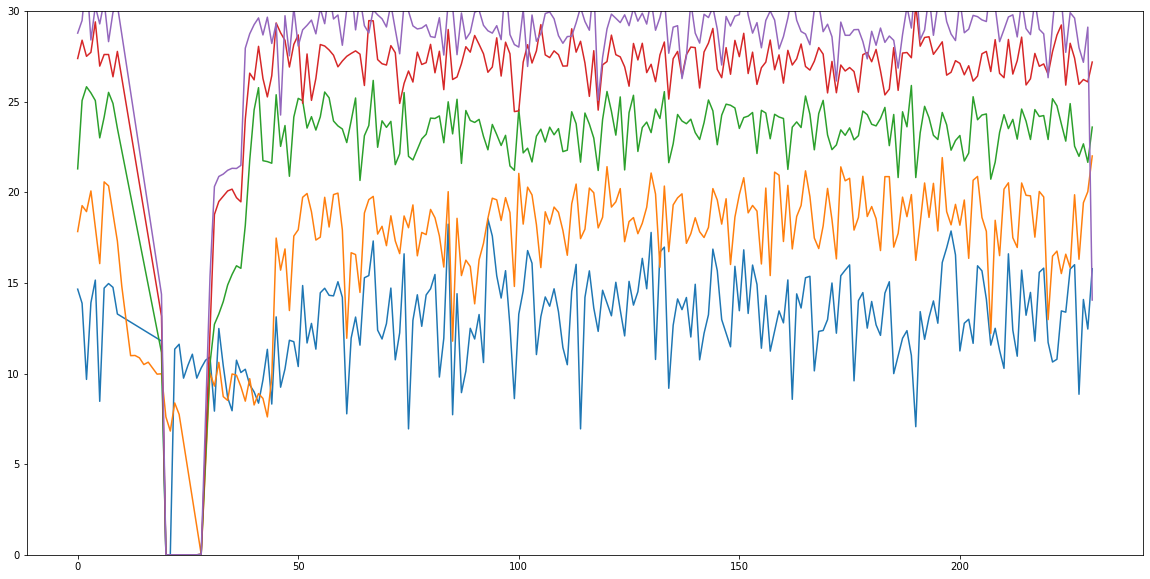

In [131]:
fig, ax = plt.subplots(1, figsize=(20,10))
ax.plot(inci_data[60, :, :, 2].T)
#ax.set_xlim(0 , 100)
ax.set_ylim(0, 30)

In [132]:
#[edge_to_ind[edge] for edge in upstream_edges]

(0.0, 30.0)

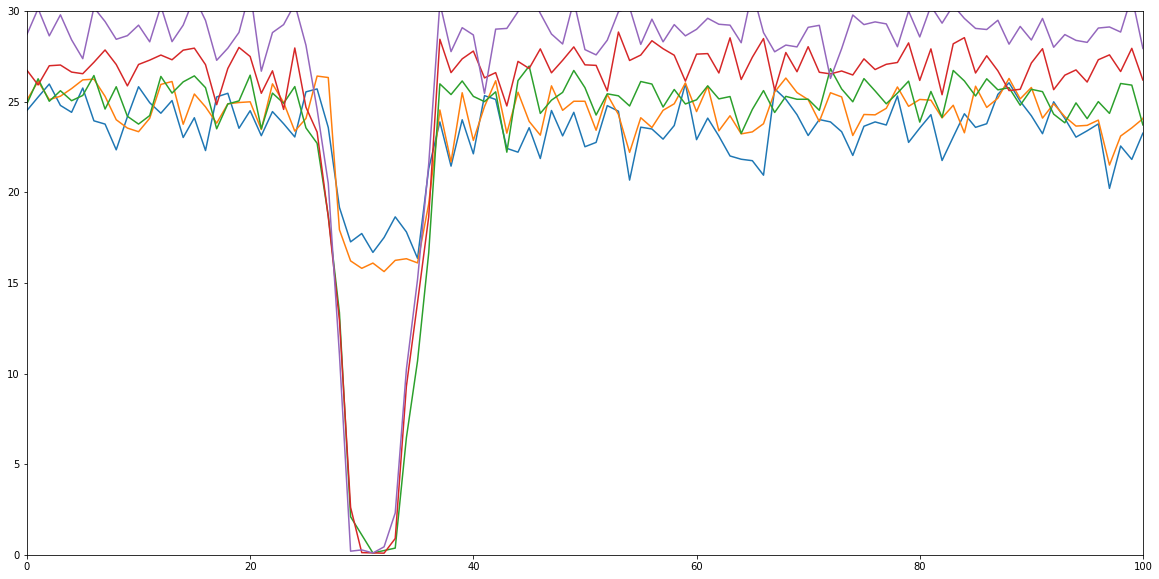

In [133]:
fig, ax = plt.subplots(1, figsize=(20,10))
ax.plot(inci_data[131, :, :, 2].T)
ax.set_xlim(0 , 100)
ax.set_ylim(0, 30)

In [134]:
residual_data = inci_data - counter_data[:, :, :,:]

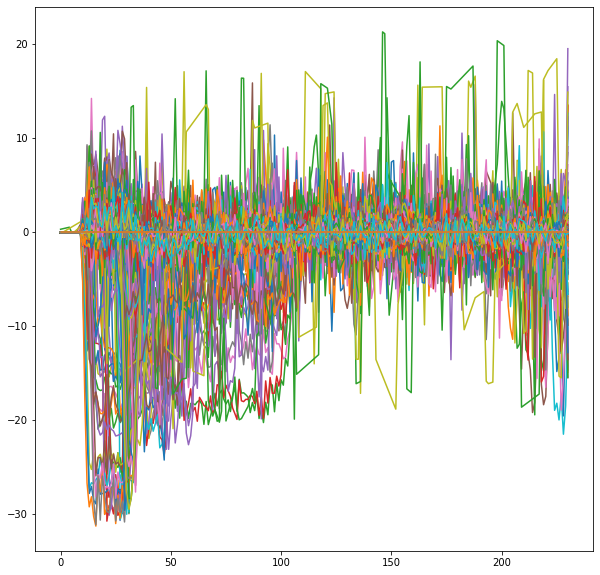

In [135]:
fig, ax = plt.subplots(1, figsize=(10,10))
_ = ax.plot(residual_data[:,:, : ,2].reshape(-1, 231).T)

In [137]:
residual_data.shape[1]

6

In [138]:
lane_stds = counter_data[...,2].std(2)

n_up = 5
n_down = 5

downstream_edges_ids = get_downstream_edges(i_edge_obj, n_down)
all_downstream_edges_ids = flatten(list(downstream_edges_ids.values()))

upstream_edges_ids = get_upstream_edges(i_edge_obj, n_up)
all_upstream_edges_ids = flatten(list(upstream_edges_ids.values()))

edge_to_level_dict = get_edge_to_level_dict(upstream_edges_ids, downstream_edges_ids, incident_edge)

relevant_edges = all_upstream_edges_ids + all_downstream_edges_ids + [incident_edge]
upstream_edges = all_upstream_edges_ids + [incident_edge]
downstream_edges = all_downstream_edges_ids + [incident_edge]

edge_to_level_dict

{'22941416#1': 'upstream_0_0',
 '4937552#1': 'upstream_0_1',
 '22941416#0': 'upstream_1_0',
 '4937552#1-AddedOnRampEdge': 'upstream_1_1',
 '54121214': 'upstream_2_0',
 '28458824': 'upstream_2_1',
 '4937552#0': 'upstream_2_2',
 '431199180': 'upstream_3_0',
 '261583464': 'upstream_3_1',
 '75259388-AddedOffRampEdge.122': 'upstream_3_2',
 '22941414': 'upstream_4_0',
 '26378010': 'upstream_4_1',
 '75259388-AddedOffRampEdge.76': 'upstream_4_2',
 '261187938-AddedOffRampEdge': 'upstream_5_0',
 '457424511#3.414': 'upstream_5_1',
 '75259388-AddedOffRampEdge.702': 'upstream_5_2',
 '360361373': 'downstream_0_0',
 '360361373.463': 'downstream_1_0',
 '360361373.981': 'downstream_2_0',
 '360361373.1498': 'downstream_3_0',
 '360361373.1899': 'downstream_4_0',
 '360361373.2215': 'downstream_5_0',
 '360361373-AddedOnRampEdge': 'incident_edge'}

In [139]:
upstream_look = [incident_edge] + all_upstream_edges_ids
upstream_look = [edge_to_ind[edge] for edge in upstream_look]
downstream_look = [incident_edge] + all_downstream_edges_ids
downstream_look = [edge_to_ind[edge] for edge in downstream_look]

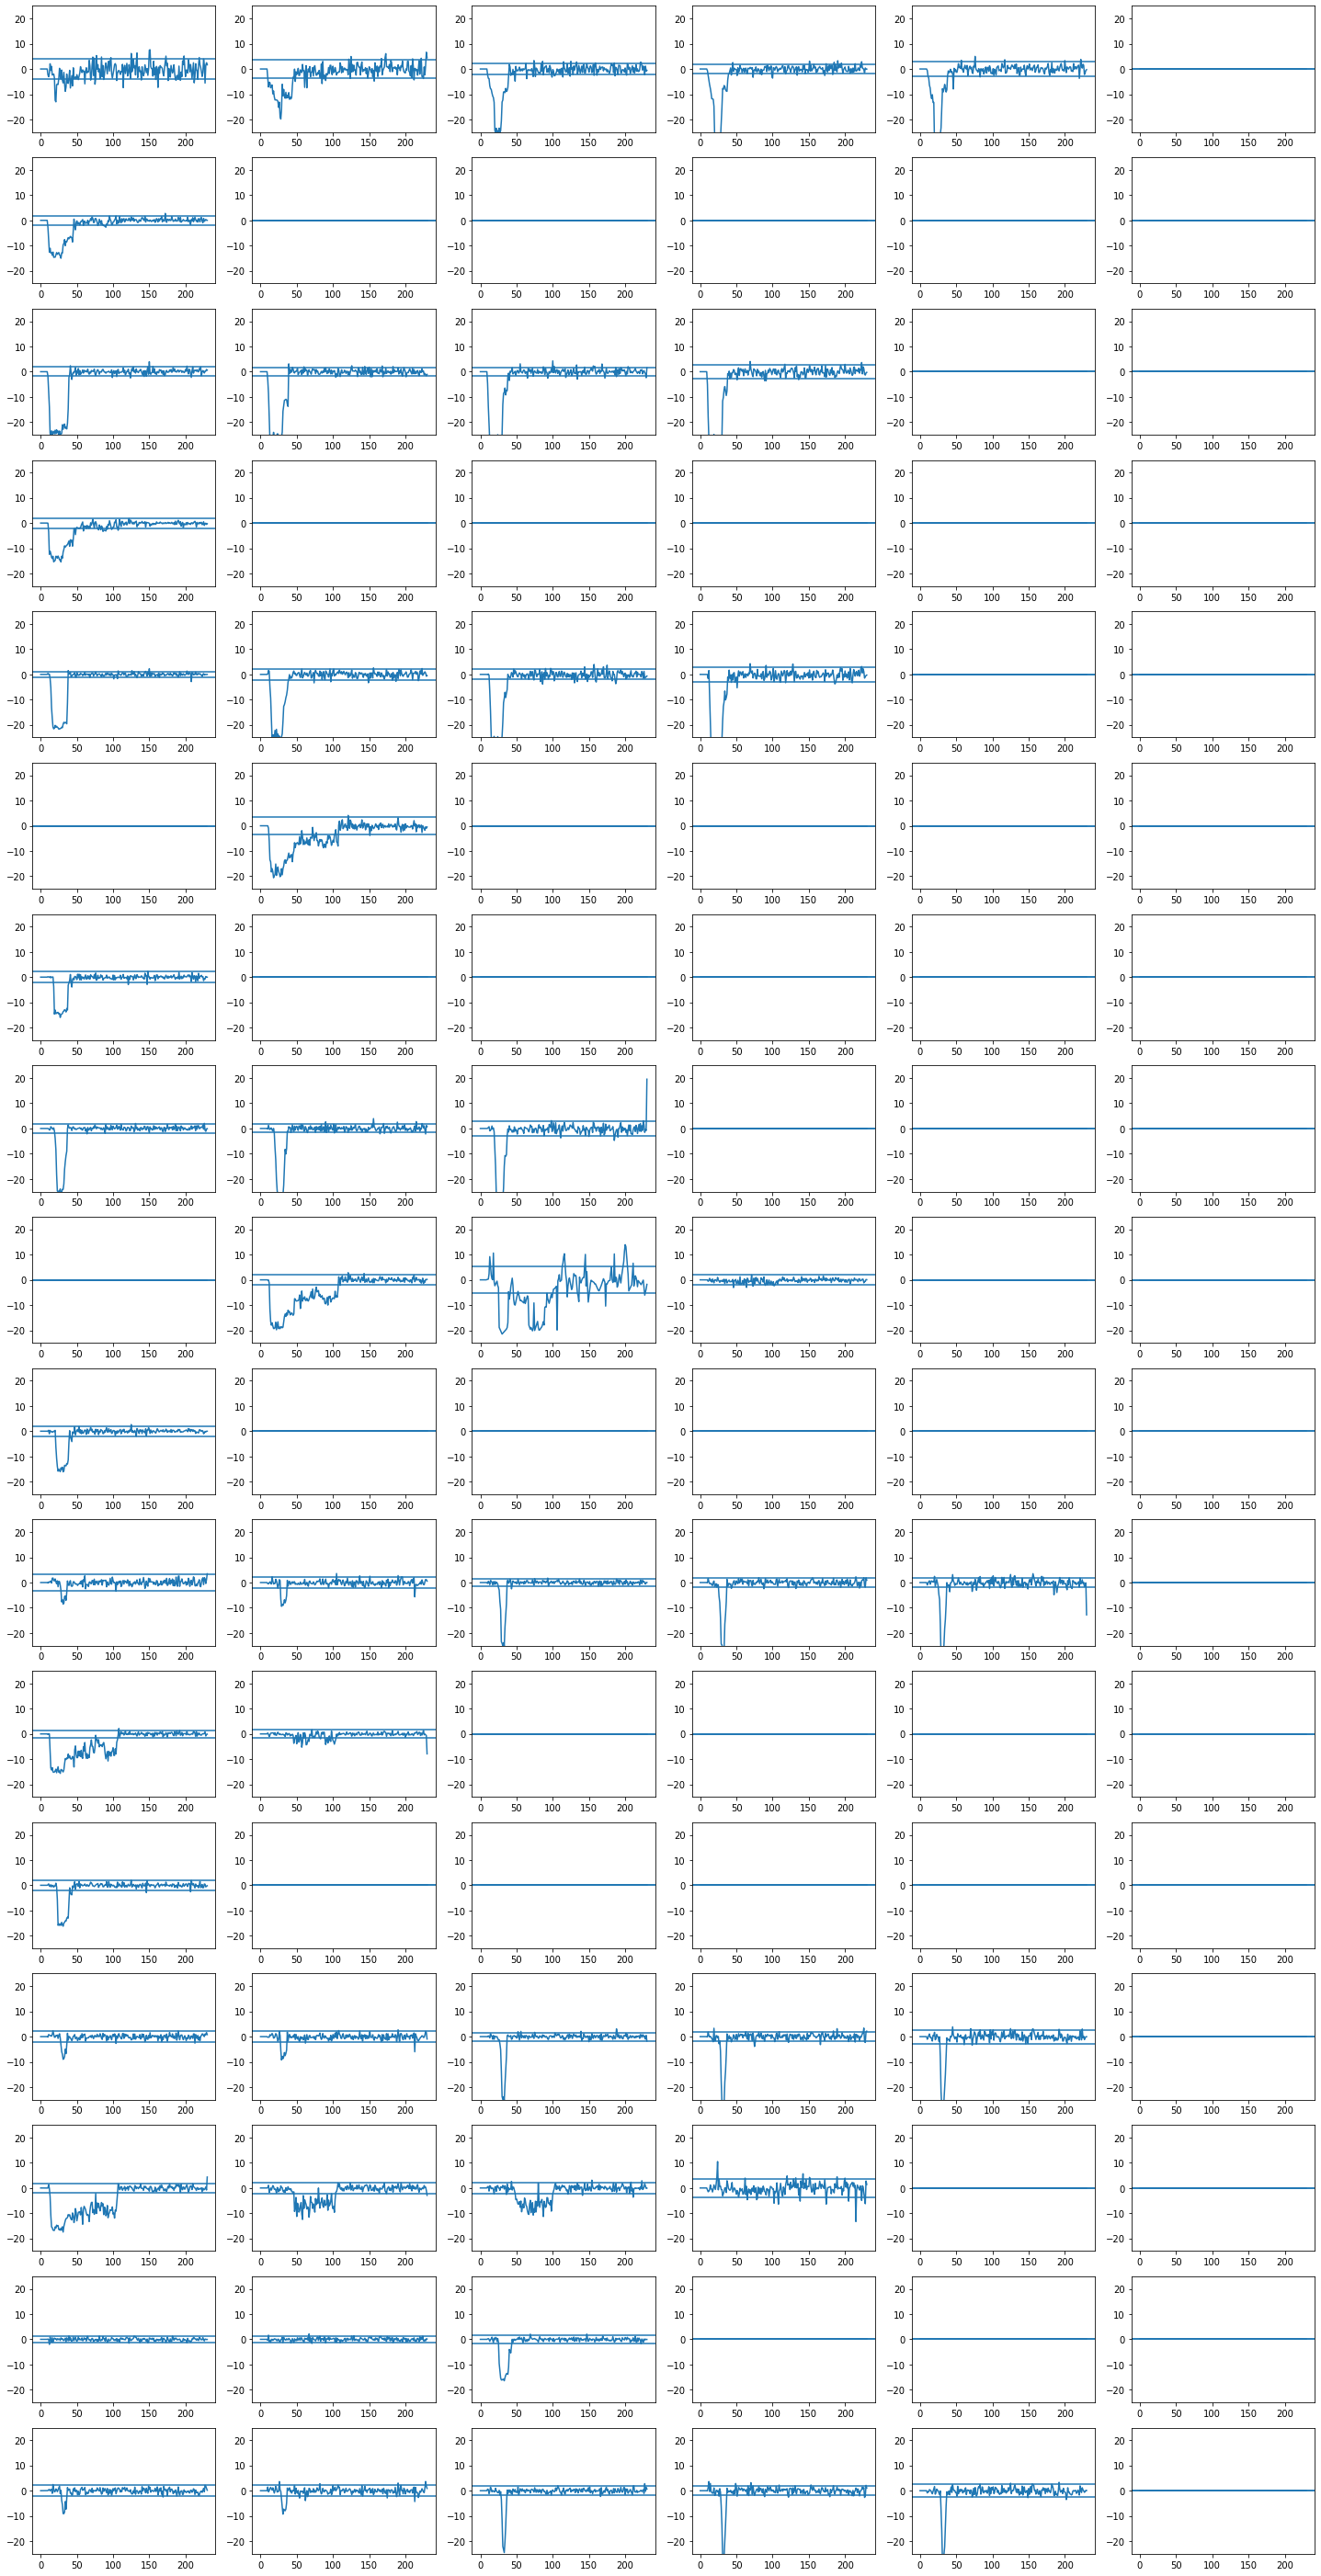

In [140]:
fig, ax = plt.subplots(len(upstream_look), 6, figsize = (25,3*len(upstream_look)))
for i, edge in enumerate(upstream_look):
    for lane in range(residual_data.shape[1]):
        ax[i,lane].plot(residual_data[edge,lane,:,2].T)
        ax[i,lane].axhline(1.95 * lane_stds[edge,lane])
        ax[i,lane].axhline(1.95 * -lane_stds[edge,lane])
        ax[i,lane].set_ylim(-25,25)
#ax.plot(residual_data.reshape(-1, 471,3)[7, : ,2])
#ax.set_xlim(0,200)

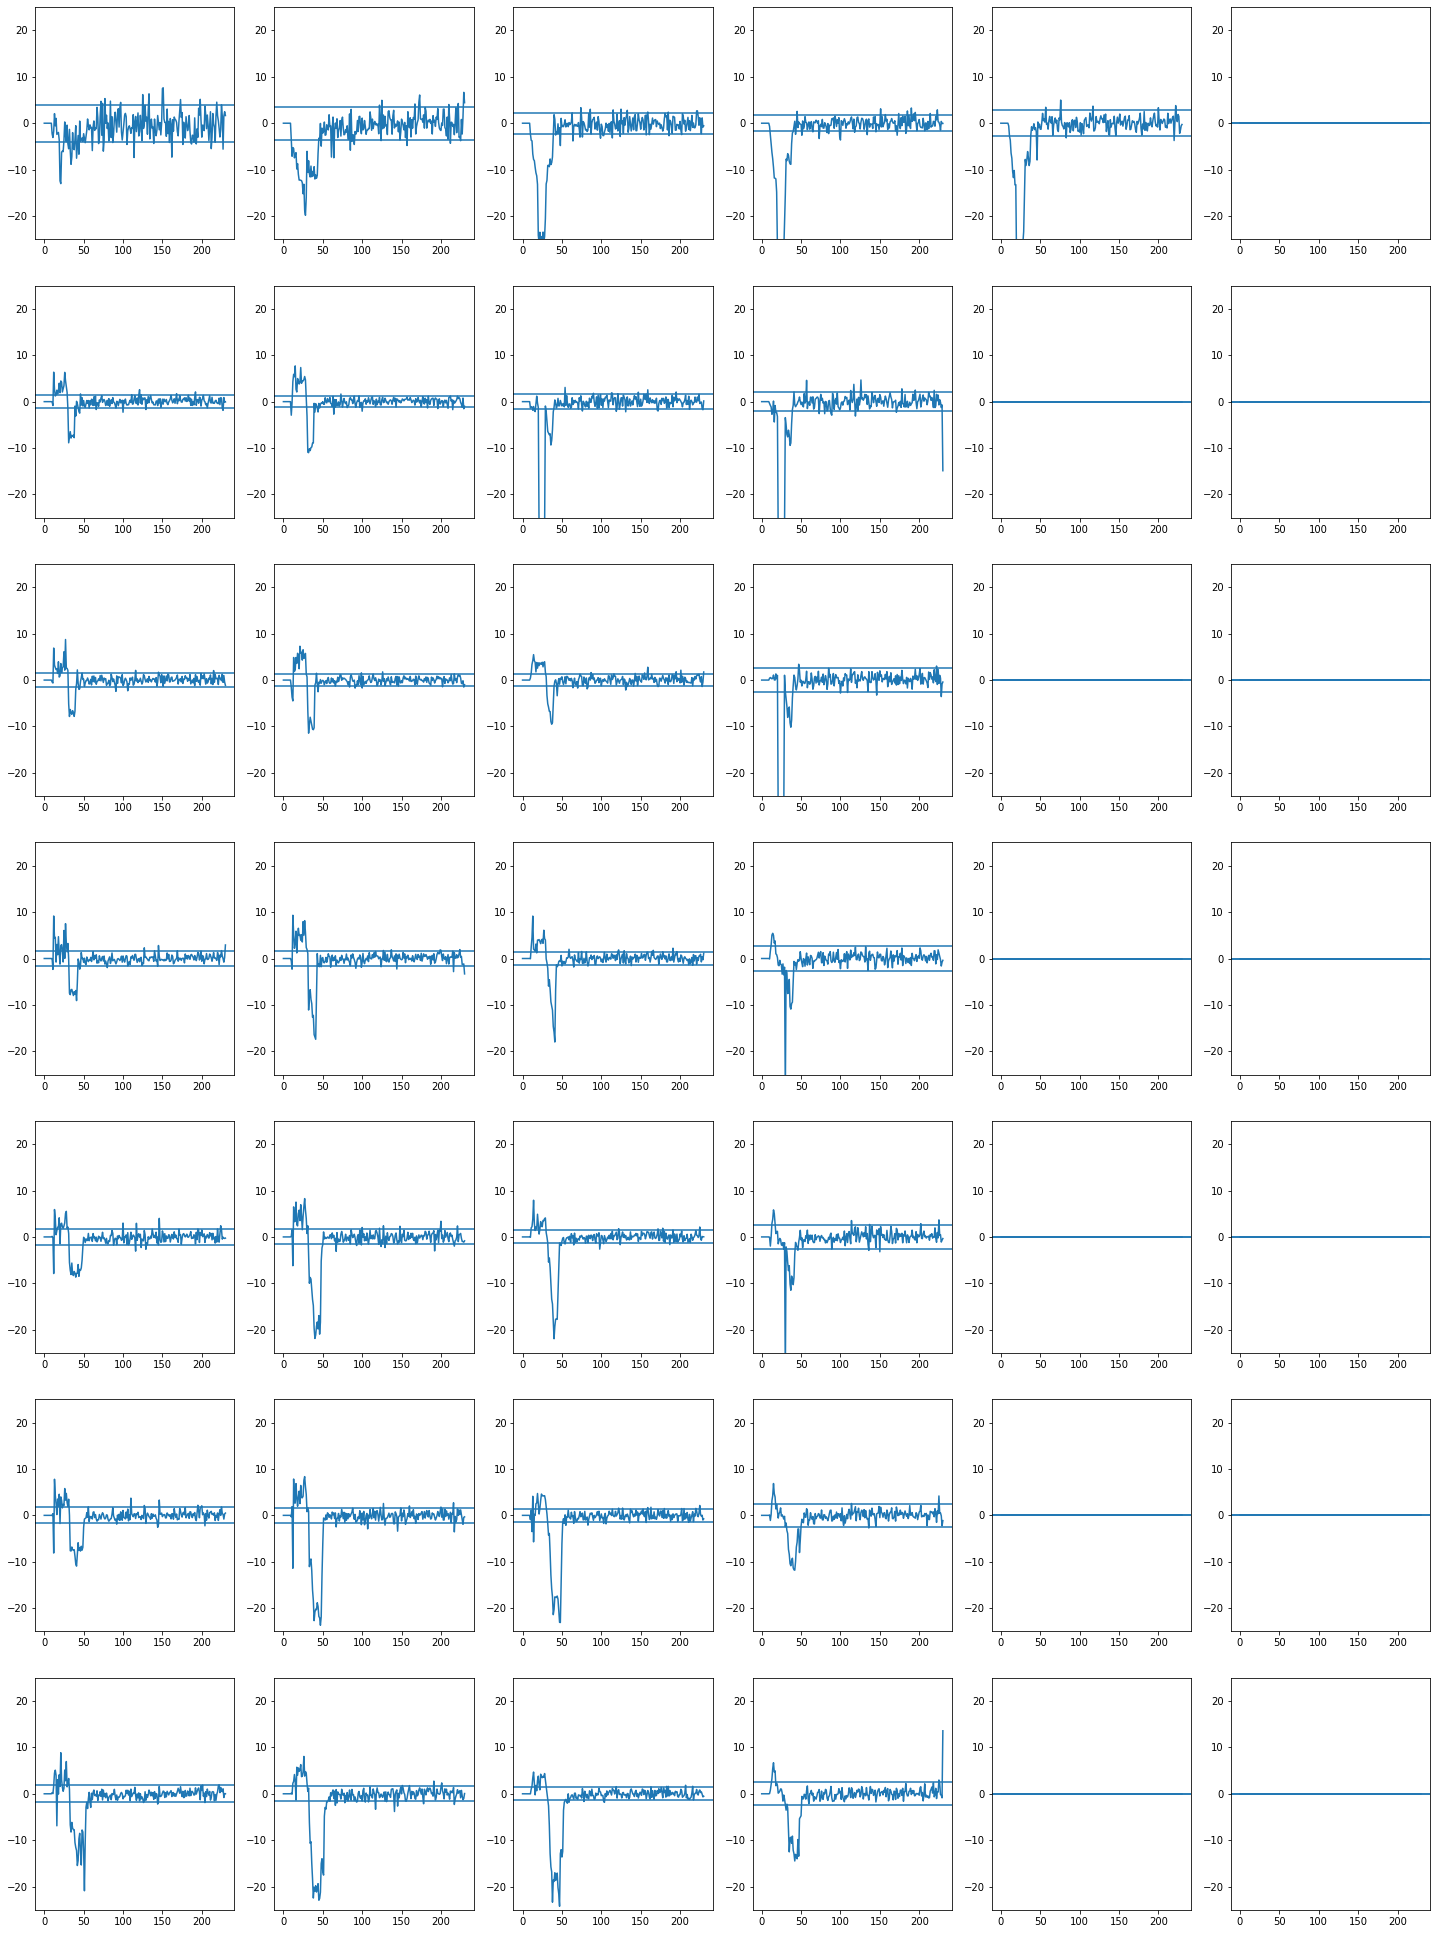

In [141]:
fig, ax = plt.subplots(len(downstream_look), 6, figsize = (25,5*len(downstream_look)))
for i, edge in enumerate(downstream_look):
    for lane in range(residual_data.shape[1]):
        ax[i,lane].plot(residual_data[edge,lane,:,2].T)
        ax[i,lane].axhline(1.95 * lane_stds[edge,lane])
        ax[i,lane].axhline(1.95 * -lane_stds[edge,lane])
        ax[i,lane].set_ylim(-25,25)
#ax.plot(residual_data.reshape(-1, 471,3)[7, : ,2])
#ax.set_xlim(0,200)

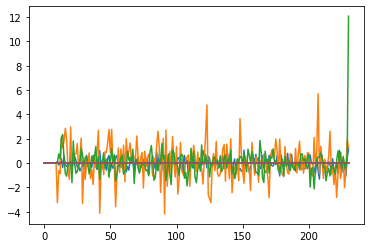

In [142]:
plt.plot(counter_data[104, :, :, 2].T - inci_data[104, :, :, 2].T)

In [143]:
def idxs_of_longest_seq(a1):
    idx_pairs = np.where(np.diff(np.hstack(([False],a1==1,[False]))))[0].reshape(-1,2)

    if len(idx_pairs) != 0:
        # Get the island lengths, whose argmax would give us the ID of longest island.
        # Start index of that island would be the desired output
        idxs_longest_seq = idx_pairs[np.diff(idx_pairs,axis=1).argmax()]
        length_seq = np.diff(idxs_longest_seq)[0]
    else:
        idxs_longest_seq = np.array([0, len(a1)])
        length_seq = 0
    return idxs_longest_seq, length_seq


# Backlog based on counterfactual

In [144]:
lane_stds = counter_data[...,2].std(2)
residual_speed = residual_data[...,2]
affect_bool_arr = (residual_speed.transpose(2,0,1) < -1.95*lane_stds)
arr = affect_bool_arr.transpose(1,2,0).reshape(-1, 231)
longest_affect_idxs, longest_affect_lengths = zip(*[idxs_of_longest_seq(row) for row in arr])
longest_affect_lengths = np.stack(longest_affect_lengths).reshape(147,6)
longest_affect_idxs = np.stack(longest_affect_idxs).reshape(147,6,2)
affected_edges = (longest_affect_lengths > 20).any(axis=1)
edge_idxs = np.where(affected_edges)[0]
affected_edges.sum()


18

In [145]:
[ind_to_edge[edge] for edge in edge_idxs]

['22941414',
 '22941416#0',
 '22941416#1',
 '261187938',
 '261187938-AddedOffRampEdge',
 '28458824',
 '293596618#1-AddedOffRampEdge',
 '360361373',
 '360361373-AddedOffRampEdge',
 '360361373-AddedOnRampEdge',
 '360361373.2215',
 '360361373.2643',
 '431199180',
 '4414080#0',
 '492226831',
 '4937552#1',
 '4937552#1-AddedOnRampEdge',
 '54121214']

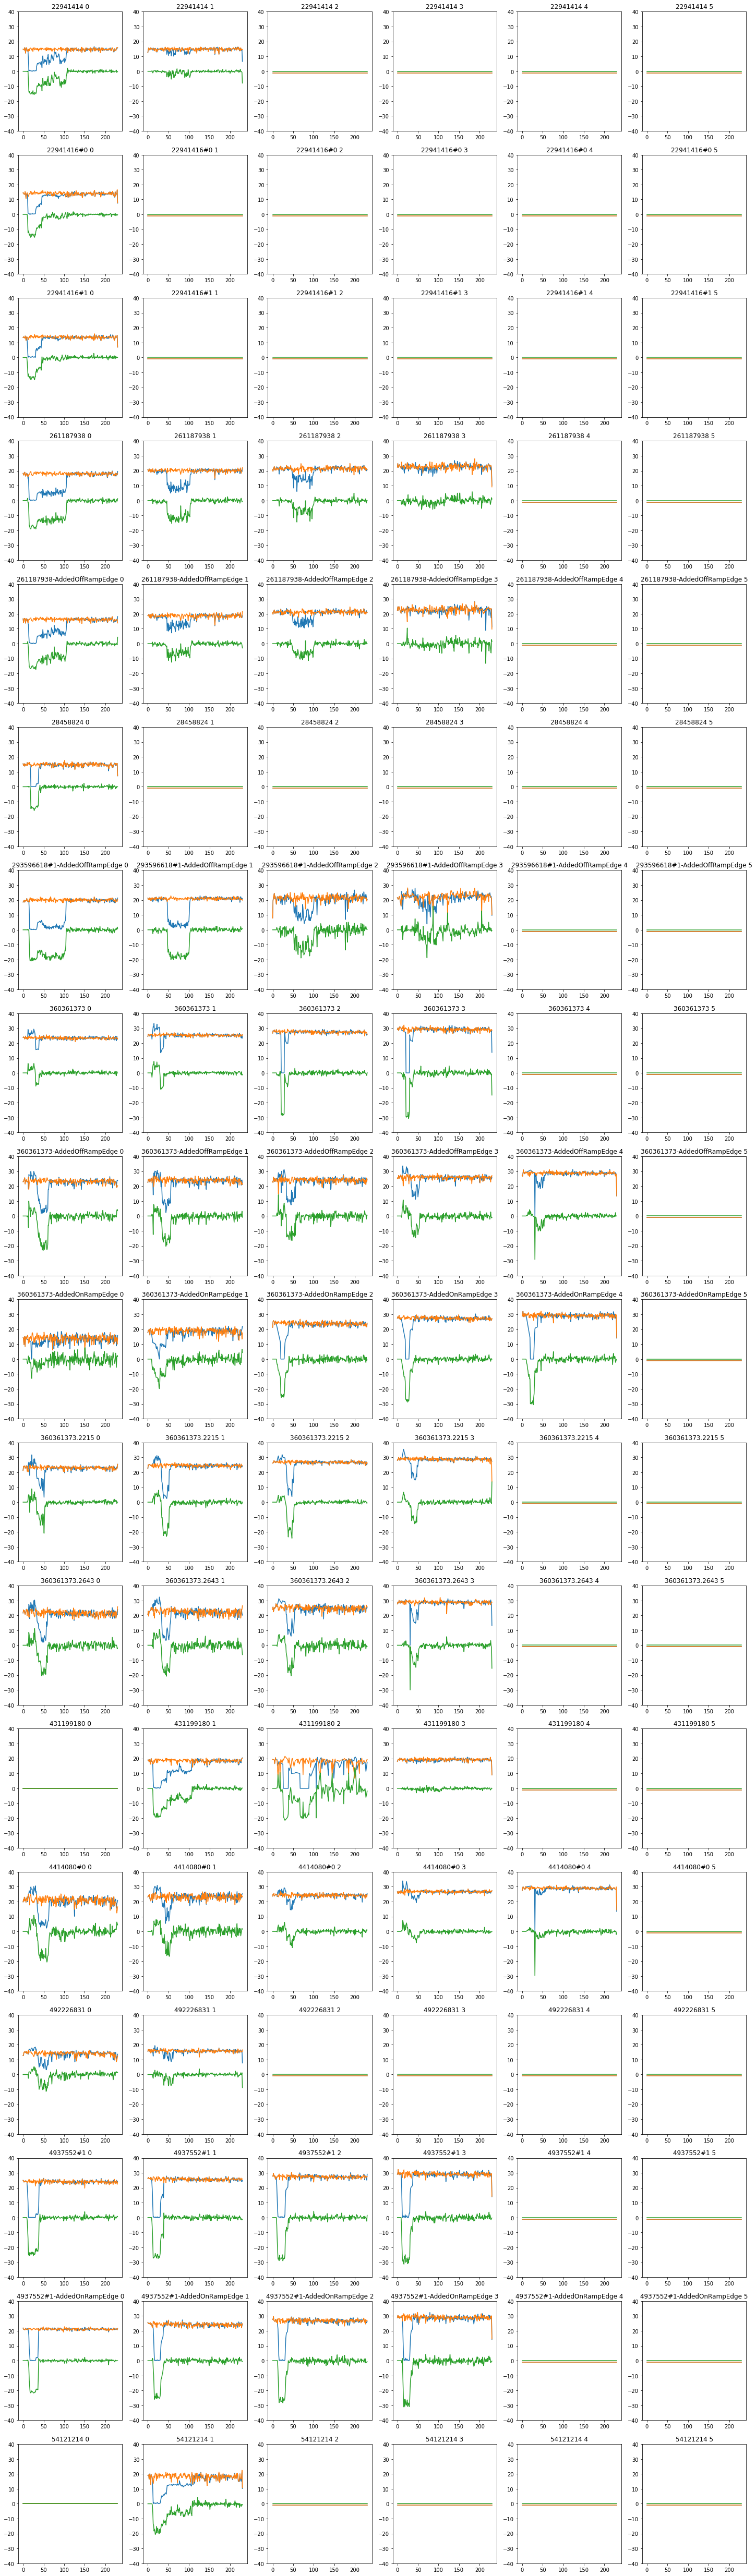

In [152]:
fig, ax = plt.subplots(len(edge_idxs), 6, figsize = (25,5*len(edge_idxs)))
for i, edge in enumerate(edge_idxs):
    for lane in range(residual_data.shape[1]):
        ax[i,lane].plot(inci_data[edge,lane,:,2].T)
        ax[i,lane].plot(counter_data[edge,lane,:,2].T)
        ax[i,lane].plot(residual_data[edge,lane,:,2].T)
        #x[i,lane].axhline(1.95 * lane_stds[edge,lane])
        #x[i,lane].axhline(1.95 * -lane_stds[edge,lane])
        ax[i,lane].set_ylim(-40, 40)
        ax[i,lane].set_title(f'{ind_to_edge[edge]} {lane}')
#ax.plot(residual_data.reshape(-1, 471,3)[7, : ,2])
#ax.set_xlim(0,200)

<AxesSubplot:>

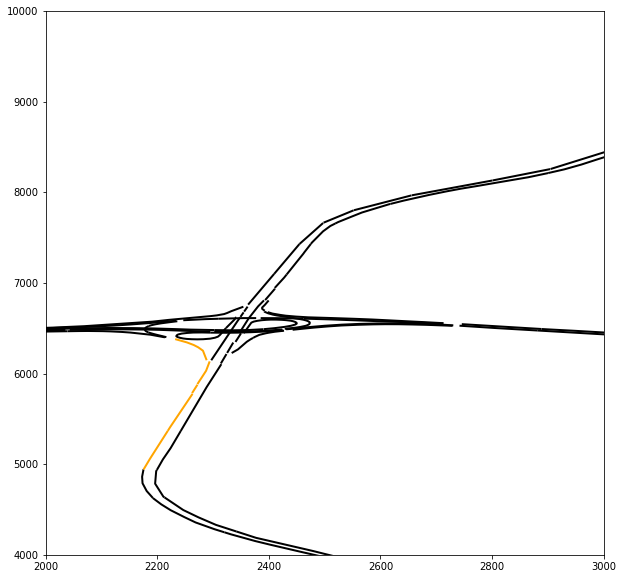

In [149]:
plot_options = {'defaultColor': 'black',
                'defaultWidth': 2}
plot_options = DotDict(plot_options)
edge_colors = {incident_edge: 'red'}

for idx in edge_idxs:
        edge_colors[ind_to_edge[idx]] = 'orange'

edge_colors[incident_edge] = 'red'        

fig, ax = plt.subplots(1, figsize=(10,10))
area = {'xmin':2000 , 'xmax':3000 ,'ymin':4000 ,'ymax':10000 }
plotNet(net, edge_colors, {}, plot_options, i_edge_obj, ax, area=area)



<AxesSubplot:>

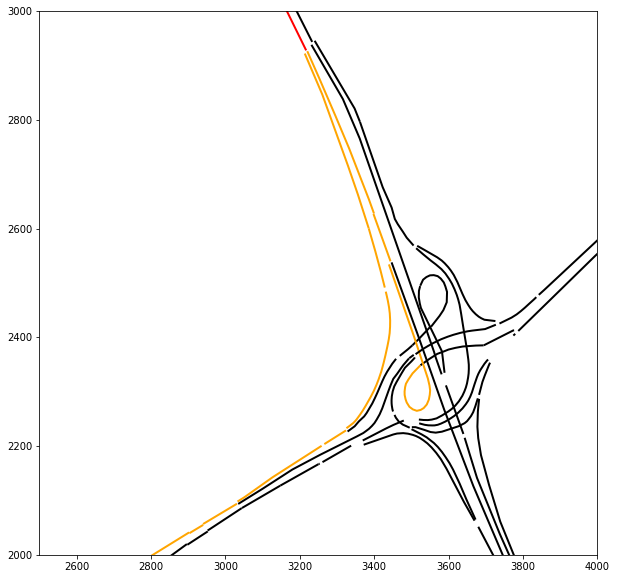

In [165]:
fig, ax = plt.subplots(1, figsize=(10,10))
area = {'xmin':2500 , 'xmax':4000 ,'ymin':2000 ,'ymax':3000 }
plotNet(net, edge_colors, {}, plot_options, i_edge_obj, ax, area=area)

# Backlog based on LoS

In [206]:
inci_speed = inci_data[...,2]
inci_speed_bool = inci_speed.transpose(2,0,1) < 5
inci_speed_bool[:, ~lane_mask] = False
arr = inci_speed_bool.transpose(1,2,0).reshape(-1, 231)
longest_affect_idxs, longest_affect_lengths = zip(*[idxs_of_longest_seq(row) for row in arr])
longest_affect_lengths = np.stack(longest_affect_lengths).reshape(147,6)
longest_affect_idxs = np.stack(longest_affect_idxs).reshape(147,6,2)
affected_edges = (longest_affect_lengths > 20).any(axis=1)
edge_idxs = np.where(affected_edges)[0]
affected_edges.sum()


14

In [207]:
lane_mask.shape

(147, 6)

In [208]:
inci_speed = inci_data[...,2]
inci_speed_bool = inci_speed.transpose(2,0,1) < 5

In [209]:
inci_speed_bool.sum(0)

array([[  0,   0,   0,   0, 231, 231],
       [  0,  14,   0,   0,   0, 231],
       [  0,   0,   0,   0, 231, 231],
       [  0,   6,   0,   0, 231, 231],
       [  0,  14,   0,   0, 231, 231],
       [  0,  18,   0,   0, 231, 231],
       [  0,  19,   1,   0, 231, 231],
       [  0,   0,   0,   0, 231, 231],
       [  0,   0,   0, 231, 231, 231],
       [  0,   0,   0,   0, 231, 231],
       [  1, 231, 231, 231, 231, 231],
       [  0,   1, 231, 231, 231, 231],
       [  0,   1, 231, 231, 231, 231],
       [  0,   0, 231, 231, 231, 231],
       [  0,   0,   0,   0,   0, 231],
       [  0,   0,   0, 231, 231, 231],
       [  0,   0, 231, 231, 231, 231],
       [  0,   0,   5, 231, 231, 231],
       [  0,   0, 231, 231, 231, 231],
       [  0,   0,   0, 231, 231, 231],
       [  0,   0, 231, 231, 231, 231],
       [  0, 231, 231, 231, 231, 231],
       [  0,  16, 231, 231, 231, 231],
       [  0, 231, 231, 231, 231, 231],
       [  0, 231, 231, 231, 231, 231],
       [  0, 231, 231, 23

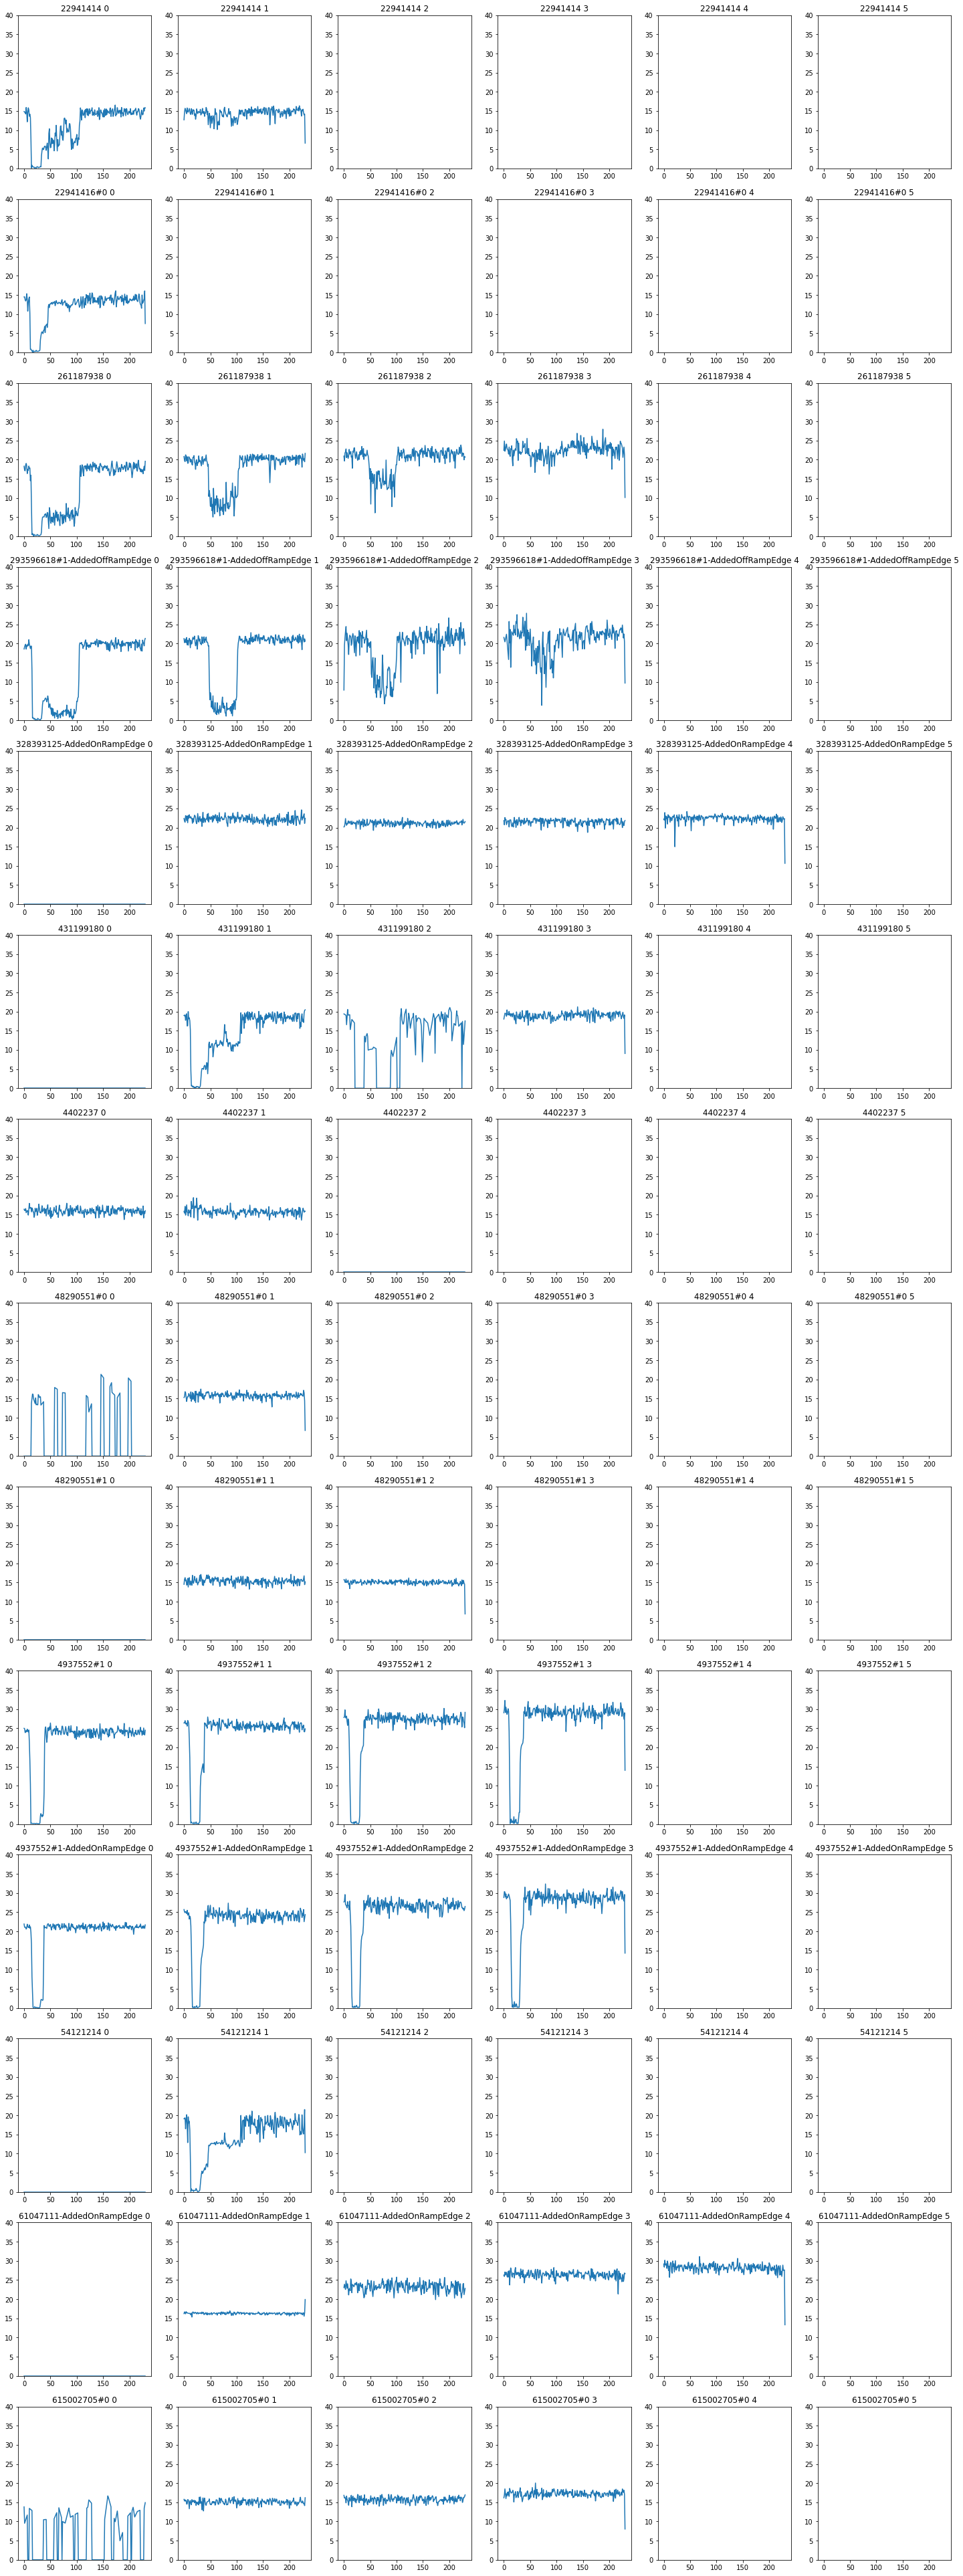

In [210]:
fig, ax = plt.subplots(len(edge_idxs), 6, figsize = (25,5*len(edge_idxs)))
for i, edge in enumerate(edge_idxs):
    for lane in range(residual_data.shape[1]):
        ax[i,lane].plot(inci_data[edge,lane,:,2].T)
        #x[i,lane].axhline(1.95 * lane_stds[edge,lane])
        #x[i,lane].axhline(1.95 * -lane_stds[edge,lane])
        ax[i,lane].set_ylim(0, 40)
        ax[i,lane].set_title(f'{ind_to_edge[edge]} {lane}')
#ax.plot(residual_data.reshape(-1, 471,3)[7, : ,2])
#ax.set_xlim(0,200)

<AxesSubplot:>

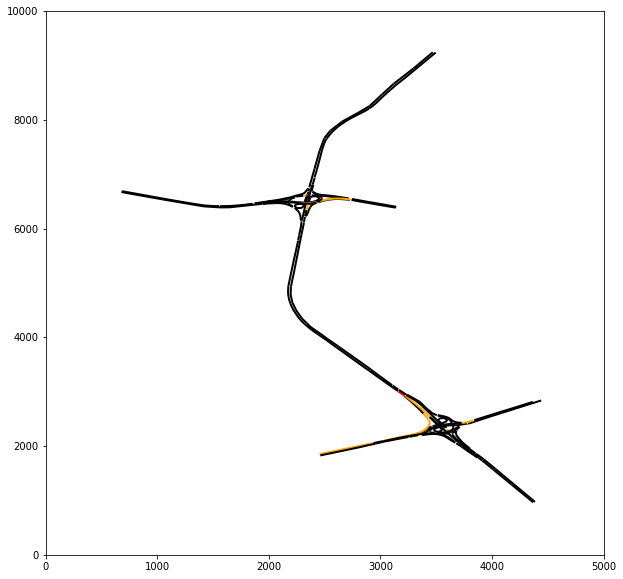

In [205]:
plot_options = {'defaultColor': 'black',
                'defaultWidth': 2}
plot_options = DotDict(plot_options)
edge_colors = {incident_edge: 'red'}

for idx in edge_idxs:
        edge_colors[ind_to_edge[idx]] = 'orange'

edge_colors[incident_edge] = 'red'        

fig, ax = plt.subplots(1, figsize=(10,10))
area = {'xmin':0 , 'xmax':5000 ,'ymin':0 ,'ymax':10000 }
plotNet(net, edge_colors, {}, plot_options, i_edge_obj, ax, area=area)



In [434]:
chosen_edges = [incident_edge]
chosen_lanes = counterfactual_detector_table.columns.str.split('_').str[1].isin(chosen_edges)



fig, ax = plt.subplots(2,2)

results_detector_table.loc['interval_speed', chosen_lanes].plot(figsize=(20,10), ax=ax[0,0], legend=False)



results_detector_table.loc['interval_occupancy', chosen_lanes].plot(figsize=(20,10), ax=ax[1,0], legend=False)



counterfactual_detector_table.loc['interval_speed', chosen_lanes].plot(figsize=(20,10), ax=ax[0,1], legend=False)



counterfactual_detector_table.loc['interval_occupancy', chosen_lanes].plot(figsize=(20,10), ax=ax[1,1], legend=False)






ax[0,0].set_title(f'Incident on edge {incident_settings["edge"]} lanes {incident_settings["lanes"]} pos {incident_settings["pos"]}')
ax[0,1].set_title(f'Counterfactual')

#ax[0,0].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 2500)
#ax[1,0].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 2500)
#ax[0,1].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 2500)
#ax[1,1].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 2500)
ax[0,0].set_ylim(-1, 30)
ax[1,0].set_ylim(-1, 100)
ax[0,1].set_ylim(-1, 30)
ax[1,1].set_ylim(-1, 100)

ax[0,0].axvline(incident_settings['start_time'], color='grey', alpha=0.5)
ax[1,0].axvline(incident_settings['start_time'], color='grey', alpha=0.5)
ax[0,0].axvline(incident_settings['start_time'] + 0.5 * incident_settings['duration_time'], color='grey', alpha=0.5)
ax[1,0].axvline(incident_settings['start_time'] + 0.5 * incident_settings['duration_time'], color='grey', alpha=0.5)

handles, labels = ax[0,0].get_legend_handles_labels()
#lgd = fig.legend(handles, [edge_to_level_dict[label] for label in labels], loc='lower center', bbox_to_anchor=(0.5, 0.0), ncol=5)
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.0), ncol=5)

NameError: name 'counterfactual_detector_table' is not defined

In [ ]:
chosen_edges = upstream_edges

fig, ax = plt.subplots(2,2)

results_detector_table[chosen_edges].loc['interval_speed'].plot(figsize=(20,10), ax=ax[0,0], legend=False)



results_detector_table[chosen_edges].loc['interval_occupancy'].plot(figsize=(20,10), ax=ax[1,0], legend=False)



counterfactual_detector_table[chosen_edges].loc['interval_speed'].plot(figsize=(20,10), ax=ax[0,1], legend=False)



counterfactual_detector_table[chosen_edges].loc['interval_occupancy'].plot(figsize=(20,10), ax=ax[1,1], legend=False)






ax[0,0].set_title(f'Incident on edge {incident_settings["edge"]} lanes {incident_settings["lanes"]} pos {incident_settings["pos"]}')
ax[0,1].set_title(f'Counterfactual')

ax[0,0].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 2500)
ax[1,0].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 2500)
ax[0,1].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 2500)
ax[1,1].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 2500)
ax[0,0].set_ylim(-1, 30)
ax[1,0].set_ylim(-1, 100)
ax[0,1].set_ylim(-1, 30)
ax[1,1].set_ylim(-1, 100)

ax[0,0].axvline(incident_settings['start_time'], color='grey', alpha=0.5)
ax[1,0].axvline(incident_settings['start_time'], color='grey', alpha=0.5)
ax[0,0].axvline(incident_settings['start_time'] + 0.5 * incident_settings['duration_time'], color='grey', alpha=0.5)
ax[1,0].axvline(incident_settings['start_time'] + 0.5 * incident_settings['duration_time'], color='grey', alpha=0.5)

handles, labels = ax[0,0].get_legend_handles_labels()
lgd = fig.legend(handles, [edge_to_level_dict[label] for label in labels], loc='lower center', bbox_to_anchor=(0.5, 0.0), ncol=5)

In [ ]:
chosen_edges = downstream_edges

fig, ax = plt.subplots(2,2)

results_detector_table[chosen_edges].loc['interval_speed'].plot(figsize=(20,10), ax=ax[0,0], legend=False)
results_detector_table[chosen_edges].loc['interval_occupancy'].plot(figsize=(20,10), ax=ax[1,0], legend=False)

counterfactual_detector_table[chosen_edges].loc['interval_speed'].plot(figsize=(20,10), ax=ax[0,1], legend=False)
counterfactual_detector_table[chosen_edges].loc['interval_occupancy'].plot(figsize=(20,10), ax=ax[1,1], legend=False)

ax[0,0].set_title(f'Incident on edge {incident_settings["edge"]} lanes {incident_settings["lanes"]} pos {incident_settings["pos"]}')
ax[0,1].set_title(f'Counterfactual')
ax[0,0].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 5000)
ax[1,0].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 5000)
ax[0,1].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 5000)
ax[1,1].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 5000)
ax[0,0].set_ylim(0, 30)
ax[1,0].set_ylim(0, 100)
ax[0,1].set_ylim(0, 30)
ax[1,1].set_ylim(0, 100)
ax[0,0].axvline(incident_settings['start_time'], color='grey', alpha=0.5)
ax[1,0].axvline(incident_settings['start_time'], color='grey', alpha=0.5)
ax[0,0].axvline(incident_settings['start_time'] + 0.5 * incident_settings['duration_time'], color='grey', alpha=0.5)
ax[1,0].axvline(incident_settings['start_time'] + 0.5 * incident_settings['duration_time'], color='grey', alpha=0.5)

handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, [edge_to_level_dict[label] for label in labels], loc='upper center', bbox_to_anchor=(0.5, -0.001), ncol=5)

In [ ]:
# Do the mean thing

In [ ]:
results_detector_table.loc['interval_speed']

In [ ]:
chosen_edges = upstream_edges

fig, ax = plt.subplots(2,2)

results_detector_table[chosen_edges].loc['interval_speed'].rolling(2).mean().iloc[1::2].plot(figsize=(20,10), ax=ax[0,0], legend=False)



results_detector_table[chosen_edges].loc['interval_occupancy'].rolling(2).mean().iloc[1::2].plot(figsize=(20,10), ax=ax[1,0], legend=False)



counterfactual_detector_table[chosen_edges].loc['interval_speed'].rolling(2).mean().iloc[1::2].plot(figsize=(20,10), ax=ax[0,1], legend=False)



counterfactual_detector_table[chosen_edges].loc['interval_occupancy'].rolling(2).mean().iloc[1::2].plot(figsize=(20,10), ax=ax[1,1], legend=False)






ax[0,0].set_title(f'Incident on edge {incident_settings["edge"]} lanes {incident_settings["lanes"]} pos {incident_settings["pos"]}')
ax[0,1].set_title(f'Counterfactual')

ax[0,0].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 5000)
ax[1,0].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 5000)
ax[0,1].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 5000)
ax[1,1].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 5000)
ax[0,0].set_ylim(0, 30)
ax[1,0].set_ylim(0, 100)
ax[0,1].set_ylim(0, 30)
ax[1,1].set_ylim(0, 100)

ax[0,0].axvline(incident_settings['start_time'], color='grey', alpha=0.5)
ax[1,0].axvline(incident_settings['start_time'], color='grey', alpha=0.5)
ax[0,0].axvline(incident_settings['start_time'] + 0.5 * incident_settings['duration_time'], color='grey', alpha=0.5)
ax[1,0].axvline(incident_settings['start_time'] + 0.5 * incident_settings['duration_time'], color='grey', alpha=0.5)

handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, [edge_to_level_dict[label] for label in labels], loc='upper center', bbox_to_anchor=(0.5, -0.001), ncol=5)

In [ ]:
chosen_edges = upstream_edges
n_mean = 1

fig, ax = plt.subplots(2,2)

results_detector_table[chosen_edges].loc['interval_speed'].rolling(n_mean).mean().iloc[1::n_mean].plot(figsize=(20,10), ax=ax[0,0], legend=False)



results_detector_table[chosen_edges].loc['interval_occupancy'].rolling(n_mean).mean().iloc[1::n_mean].plot(figsize=(20,10), ax=ax[1,0], legend=False)



counterfactual_detector_table[chosen_edges].loc['interval_speed'].rolling(n_mean).mean().iloc[1::n_mean].plot(figsize=(20,10), ax=ax[0,1], legend=False)



counterfactual_detector_table[chosen_edges].loc['interval_occupancy'].rolling(n_mean).mean().iloc[1::n_mean].plot(figsize=(20,10), ax=ax[1,1], legend=False)






ax[0,0].set_title(f'Incident on edge {incident_settings["edge"]} lanes {incident_settings["lanes"]} pos {incident_settings["pos"]}')
ax[0,1].set_title(f'Counterfactual')

ax[0,0].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 5000)
ax[1,0].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 5000)
ax[0,1].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 5000)
ax[1,1].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 5000)
ax[0,0].set_ylim(0, 30)
ax[1,0].set_ylim(0, 100)
ax[0,1].set_ylim(0, 30)
ax[1,1].set_ylim(0, 100)

ax[0,0].axvline(incident_settings['start_time'], color='grey', alpha=0.5)
ax[1,0].axvline(incident_settings['start_time'], color='grey', alpha=0.5)
ax[0,0].axvline(incident_settings['start_time'] + 0.5 * incident_settings['duration_time'], color='grey', alpha=0.5)
ax[1,0].axvline(incident_settings['start_time'] + 0.5 * incident_settings['duration_time'], color='grey', alpha=0.5)

handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, [edge_to_level_dict[label] for label in labels], loc='upper center', bbox_to_anchor=(0.5, -0.001), ncol=5)

# Create dataset from simulation

## How to create sequences from simulation

- Do we even do sequence to sequence?
- Do we make multiple sequences from each simulation or is each simulation separate?
- Should the incident happen the same time along the sequence for all of the simulations?
- Should sequences be the same length?
    - If we do backlog then no they should vary in length
    
## Create backlog from comparing incident with counterfactual

- Should it even be created looking at the counterfactual?
- How big a difference is necessary?
    -- Could be based on the LoS from the highway manual
- If this is model output how do we get a model to output it?
    - Some sequence model with a way to determine how to stop
        - This sounds like some NLP like problem